# Importing Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
from numpy.linalg import inv

import time

from matplotlib.animation import FuncAnimation
from IPython import display
from matplotlib import animation
from IPython.display import HTML

In [2]:
import warnings # Serve para ignorar mensagens de alerta que aparecem 
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
plt.rcParams['font.size'] = 14

# Objective

- Resolve the Kuramoto-Sivashinsky equation with a compact finite element scheme

#  Kuramoto-Sivashinky Equation (KSE)

Formula:

\begin{equation}
    \frac{\partial u}{\partial t} =  -\beta\frac{\partial^4 u}{\partial u^4}- \alpha\frac{\partial^2 u}{\partial x^2} - u\frac{\partial u}{\partial x}  
\end{equation}

Where $\beta$ and $ \alpha, $ are constants

## Creating the domain

Based on reference [2], we consider a spatial domain $\Omega_x = [a,b]$ and a time domain $\Omega_T = [0,T]$

Defining the constant values:

$b = 200$ 

$a = 0$ 

$\beta = 1$ 

$\alpha = 1$

Uniform grids must be formed by a set of nodes $x$ and $t$. Following reference [1], we define the spatial spacing $\Delta_x$ from the length of the domain and the number of nodes $N$:

$\Delta_x = \frac{b-a}{N-1}$

The time step $\Delta_t$ is defined by the user. 

In [4]:
N = 256 # Number of nodes 
a = 0
b = 200

dx = (b-a)/(N-1) 
dt = 0.05
T = 2000

# Creating the domains

x = np.linspace(a,b,N)     
t = np.arange(0,T+dt,dt)      

## Inicial condition

The initial periodic condition of reference [2] is defined as:

\begin{equation}
    u_0 = cos \left(\frac{\pi x}{20}\right) \left(1+sin\frac{\pi x}{20}\right)
\end{equation}

Text(0, 0.5, 'Initial condition')

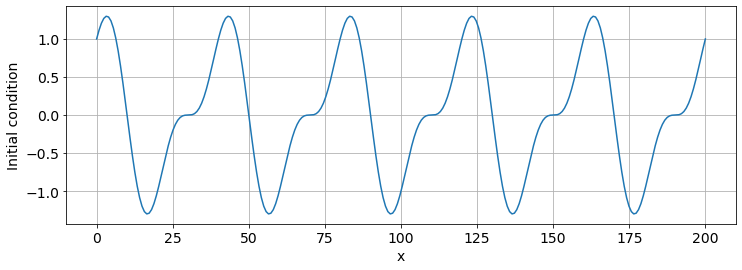

In [5]:
u0 = np.cos(np.pi*x/20)*(1+np.sin(np.pi*x/20))

plt.figure(figsize=(12, 4))
plt.plot(x,u0)
plt.grid()
plt.xlabel('x')
plt.ylabel('Initial condition')

In [6]:
u_num = np.zeros((len(t),len(x))) # Matrix where I will save the solution at each time step as a row.

# Applying initial condition 
u_num[0,:] = u0
u_num

array([[1.        , 1.11437737, 1.20634371, ..., 0.73325016, 0.87046365,
        1.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

# Compact Finite Difference:

Using [3] as the main reference, we see that he didn't consider periodic boundary conditions, but [2] did. Comparing the difference between there matrixes, we can see that all of them are tridiagonal, however, the terms close to the boundary are different. 

Therefore, we can use the same scheme as in [3], but applying the periodic boundary conditions the same way as in [2]. 

## First derivative 

In [7]:
# Creating the matrix of numbers
A = np.zeros((N,N))
i,j = np.indices(A.shape,dtype=int)

A[i==j-1] = 1
A[i==j] = 3
A[i==j+1] = 1

# Correcting boundary conditions for periodic case
A[0,-1] = A[0,1]
A[-1,0] = A[-1,-2]

print(A)
A2 = inv(A)

[[3. 1. 0. ... 0. 0. 1.]
 [1. 3. 1. ... 0. 0. 0.]
 [0. 1. 3. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 3. 1. 0.]
 [0. 0. 0. ... 1. 3. 1.]
 [1. 0. 0. ... 0. 1. 3.]]


In [8]:
#A[0,:]

In [9]:
matrixpsi = np.zeros((N,N))
i,j = np.indices(matrixpsi.shape,dtype=int)

matrixpsi[i==j-2] = 1/(12*dx)
matrixpsi[i==j-1] = 28/(12*dx)
matrixpsi[i==j+1] = -28/(12*dx)
matrixpsi[i==j+2] = -1/(12*dx)

# Correcting boundary conditions for periodic case
matrixpsi[0,-1] = -matrixpsi[0,1]
matrixpsi[0,-2] = -matrixpsi[0,2]
matrixpsi[1,-1] = -matrixpsi[0,2]
matrixpsi[1,0] = -matrixpsi[0,1]

matrixpsi[-1,0] = -matrixpsi[-1,N-2]
matrixpsi[-1,1] = -matrixpsi[-1,N-3]
matrixpsi[-2,0] = -matrixpsi[-2,-4]
matrixpsi.view()

array([[ 0.     ,  2.975  ,  0.10625, ...,  0.     , -0.10625, -2.975  ],
       [-2.975  ,  0.     ,  2.975  , ...,  0.     ,  0.     , -0.10625],
       [-0.10625, -2.975  ,  0.     , ...,  0.     ,  0.     ,  0.     ],
       ...,
       [ 0.     ,  0.     ,  0.     , ...,  0.     ,  2.975  ,  0.10625],
       [ 0.10625,  0.     ,  0.     , ..., -2.975  ,  0.     ,  2.975  ],
       [ 2.975  ,  0.10625,  0.     , ..., -0.10625, -2.975  ,  0.     ]])

In [10]:
def u_x(u):
    psi = np.matmul(matrixpsi,u)
    ux = np.matmul(A2,psi)
    return ux

## Second derivative

In [11]:
B = np.zeros((N,N))

i,j = np.indices(A.shape,dtype=int)

B[i==j-1] = 1
B[i==j] = 10
B[i==j+1] = 1

# Correcting boundary conditions for periodic case
B[0,-1] = B[0,1]
B[-1,0] = B[-1,-2]
B2 = inv(B)
B 

array([[10.,  1.,  0., ...,  0.,  0.,  1.],
       [ 1., 10.,  1., ...,  0.,  0.,  0.],
       [ 0.,  1., 10., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ..., 10.,  1.,  0.],
       [ 0.,  0.,  0., ...,  1., 10.,  1.],
       [ 1.,  0.,  0., ...,  0.,  1., 10.]])

In [12]:
matrixphi = np.zeros((N,N))
i,j = np.indices(matrixphi.shape,dtype=int)


matrixphi[i==j-1] = 12/(dx**2)
matrixphi[i==j] = -(12*2)/(dx**2)
matrixphi[i==j+1] = 12/(dx**2)

# Correcting boundary conditions for periodic case
matrixphi[0,-1] = matrixphi[0,1]
matrixphi[-1,0] = matrixphi[-1,-2]
matrixphi

array([[-39.015 ,  19.5075,   0.    , ...,   0.    ,   0.    ,  19.5075],
       [ 19.5075, -39.015 ,  19.5075, ...,   0.    ,   0.    ,   0.    ],
       [  0.    ,  19.5075, -39.015 , ...,   0.    ,   0.    ,   0.    ],
       ...,
       [  0.    ,   0.    ,   0.    , ..., -39.015 ,  19.5075,   0.    ],
       [  0.    ,   0.    ,   0.    , ...,  19.5075, -39.015 ,  19.5075],
       [ 19.5075,   0.    ,   0.    , ...,   0.    ,  19.5075, -39.015 ]])

In [13]:
def u_xx(u):
    phi = np.matmul(matrixphi,u)
    uxx = np.matmul(B2,phi)
    return uxx

## Fourth derivative

In [14]:
def u_xxxx(u):
    phi = np.matmul(matrixphi,u_xx(u))
    uxxxx = np.matmul(B2,phi)   
    return uxxxx

# Plugging in the derivative values

In [15]:
beta=1
alpha=1

In [16]:
def Kuramoto(u):
    """
    Function to compute the right-hand side of the system.
    
    Parameters
    ----------
    u : numpy.ndarray
        Solution of time step t as a 1D array of floats
    
    Returns
    ----------
    u_t : numpy.ndarray
          The right-hand side of the system as a 1D array of floats
    """

    u_t = -beta*u_xxxx(u)-alpha*u_xx(u)-u*u_x(u)
    return u_t

# Solving the equation 

In [17]:
def SSP_RK43(u):
    
    u1 = u + (dt/2)*Kuramoto(u)
    u2 = u1 + (dt/2)*Kuramoto(u1)
    u3 = (2/3)*u + u2/3 + (dt/6)*Kuramoto(u2)
    u_tdt = u3 + (dt/2)*Kuramoto(u3)
    
    return u_tdt # solution at time step t+dt

In [18]:
u_hist = u_num.copy()
u_hist.shape

(40001, 256)

In [19]:
from tqdm.notebook import trange, tqdm
from time import sleep

for i in tqdm(range(len(t)-1)):
    u_num[i+1,:] = SSP_RK43(u_num[i,:])

  0%|          | 0/40000 [00:00<?, ?it/s]

# Plots

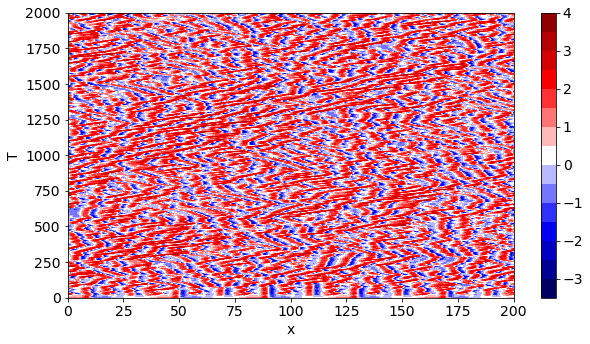

In [20]:
fig, ax = plt.subplots(figsize=(9, 5))

Xm, Tm = np.meshgrid(x,t)

surf = plt.contourf(Xm, Tm, u_num,15, cmap=plt.get_cmap("seismic"))

plt.colorbar()
plt.xlabel('x')
plt.ylabel('T')
plt.tight_layout()

In [21]:
np.save('Kuramoto_dataset\Kuramoto_X', Xm)
np.save('Kuramoto_dataset\Kuramoto_T', Tm)
np.save('Kuramoto_dataset\Kuramoto_U', u_num)

# References

[1] - Backpropagation algorithms and reservoir computing in recurrent neural networks for the forecasting of complex spatiotemporal dynamics 

[2] - A COMPACT FOURTH-ORDER IMPLICIT-EXPLICIT RUNGE-KUTTA TYPE SCHEME FOR NUMERICAL SOLUTION OF THE KURAMOTO-SIVASHINSKY EQUATION 

[3] - A note on solving the fourth-order Kuramoto-Sivanshinsky equation by the compact finite difference scheme 

[4] - A Reduced High-order Compact Finite Difference Scheme Based on Proper Orthogonal Decomposition for the Generalized Kuramoto-Sivashinsky Equation
